In [5]:
# Klasifikatoriaus konstravimas, panaudojant požymius iš csv failų.

# Požymiai įmami iš failų train_features.csv, validate_features.csv, test_features.csv
# Duomenys naudojami tf.data.dataset formatu. 

import tensorflow as tf
import pandas as pd
import numpy as np
import time
import sys, os, json
from pathlib import Path

import matplotlib.pyplot as plt

from zive_util_vu import cm2df 
from zive_util_vu import create_dir
from zive_util_vu import runtime, split_SubjCode
from zive_util_vu import get_userId, read_rec, get_filename 

print(tf.__version__)

2.6.0


In [6]:
# Pasiruošimas ir nurodomi bendri parametrai

print("Skriptas EKG įrašų pūpsnių požymių skaičiavimui")
print('Modelis CNN VU su EKG sekos reikšmėmis, EKG formos požymiais, RR intervalais prieš ir po R dantelio')

import warnings
# warnings.filterwarnings("ignore")

my_os=sys.platform
print("OS in my system : ",my_os)

if my_os != 'linux':
    OS = 'Windows'
else:  
    OS = 'Ubuntu'

# Bendras duomenų aplankas, kuriame patalpintas subfolderis name_db

if OS == 'Windows':
    Duomenu_aplankas = 'D:\DI\Data\MIT&ZIVE\VU'   # variantas: Windows, GUNDAS
    # Duomenu_aplankas = 'F:\DI\Data\MIT&ZIVE\VU'   # variantas: Windows, HERKULIS
else:
    Duomenu_aplankas = '/home/kesju/DI/Data/MIT&ZIVE/VU'   # arba variantas: UBUNTU, be Docker

# jei variantas Docker pasirenkame:
# Duomenu_aplankas = '/Data/MIT&ZIVE'

# Vietinės talpyklos aplankas ir pūpsnių atributų failas
db_folder = 'DUOM_VU'

# Vietinės talpyklos aplankas ir pūpsnių atributų failas
# all_beats_attr_fname = 'all_beats_attr_z.csv'

# Failai su požymių masyvais
train_feature_set_fname = 'train_features.csv' 
validation_feature_set_fname = 'validation_features.csv' 
test_feature_set_fname = 'test_features.csv' 

# Masyvai pūpsnių klasių formavimui
selected_beats = {'N':0, 'S':1, 'V':2}
all_beats =  {'N':0, 'S':1, 'V':2, 'U':3, 'F':3}  

# Diskretizavimo dažnis:
fs = 200

# /////////////////////////////////////////////////////////////////

#  Nuoroda į aplanką su MIT2ZIVE duomenų rinkiniu
db_path = Path(Duomenu_aplankas, db_folder)

# Nuoroda į aplanką su EKG įrašais (.npy) ir anotacijomis (.json)
rec_dir = Path(db_path, 'records_npy')

# Nuoroda į aplanką su EKG požymiais
features_dir = Path(db_path, 'sets')

# Klasių skaičius
n_classes = len(selected_beats)

# Išvedame parametrus
print("\nBendras duomenų aplankas: ", Duomenu_aplankas)
print("Zive duomenų aplankas: ", db_folder)
print("Aplankas su originaliais EKG įrašais ir anotacijomis (.json) ", rec_dir)
print("Aplankas su apskaičiuotais požymių masyvais ", features_dir)
print("Train failas su apskaičiuotais požymiais ", train_feature_set_fname)
print("Validation failas su apskaičiuotais požymiais ", validation_feature_set_fname)
print("Test failas su apskaičiuotais požymiais ", test_feature_set_fname)
# print("Pūpsnių atributų failas:", all_beats_attr_fname) - atsisakėme
print("Diskretizavimo dažnis: ", fs)
print('Klasifikavimo schema:', selected_beats)
print('Klasių skaičius:', n_classes)

print("\n")

Skriptas EKG įrašų pūpsnių požymių skaičiavimui
Modelis CNN VU su EKG sekos reikšmėmis, EKG formos požymiais, RR intervalais prieš ir po R dantelio
OS in my system :  linux

Bendras duomenų aplankas:  /home/kesju/DI/Data/MIT&ZIVE/VU
Zive duomenų aplankas:  DUOM_VU
Aplankas su originaliais EKG įrašais ir anotacijomis (.json)  /home/kesju/DI/Data/MIT&ZIVE/VU/DUOM_VU/records_npy
Aplankas su apskaičiuotais požymių masyvais  /home/kesju/DI/Data/MIT&ZIVE/VU/DUOM_VU/sets
Train failas su apskaičiuotais požymiais  train_features.csv
Validation failas su apskaičiuotais požymiais  validation_features.csv
Test failas su apskaičiuotais požymiais  test_features.csv
Diskretizavimo dažnis:  200
Klasifikavimo schema: {'N': 0, 'S': 1, 'V': 2}
Klasių skaičius: 3




In [7]:
# Here's a simple function that will pack together all the columns:
def pack(features, label):
  return tf.stack(list(features.values()), axis=-1), label

def create_dataset_from_csv(filepath, selected_columns, n_classes, batch_size):
  # Sukūriame tf.data.dataset klasės objektą duomenų skaitymui partijomis iš csv failo
  # ir darbui su klasifikatoriumi
  ds_raw = tf.data.experimental.make_csv_dataset(
      [filepath],
      batch_size=batch_size, # Artificially small to make examples easier to show.
      select_columns=selected_columns,
      label_name='label',
      num_epochs=1,
      ignore_errors=True,)

#  Kontrolinis skaitymas
  # for batch, label in ds_raw.take(1):
  #     for key, value in batch.items():
  #       print(f"{key}: {value}")
  #     print()
  #     print(f"{'y'}: {label}")  

  # Apply this to each element of the dataset:
  ds = ds_raw.map(pack)
  # Convert label to one hot tensor
  ds = ds.map(lambda x, y: (x, tf.one_hot(y, depth=n_classes)))
  return ds


selected_columns = ['label', 'RRl', 'RRr', 'RRl/RRr', 
  'signal_mean', 'signal_std', 'P_val', 'Q_val', 'R_val', 'S_val', 'T_val', 'P_pos', 'Q_pos', 'R_pos',
  'S_pos', 'T_pos', 'QRS', 'PR', 'ST', 'QT']
batch_size = 32

# Train set
filepath = os.path.join(features_dir, train_feature_set_fname)
print(f'\nPožymių masyvas iš:  {filepath}')
ds_train = create_dataset_from_csv(filepath, selected_columns, n_classes, batch_size)

# Kontrolinis skaitymas
# for features, label in ds_train.take(1):
#   print(features.numpy(), label.numpy())
  
# Validation set
filepath = os.path.join(features_dir, validation_feature_set_fname)
print(f'\nPožymių masyvas iš:  {filepath}')
ds_validation = create_dataset_from_csv(filepath, selected_columns, n_classes, batch_size)

# Kontrolinis skaitymas
# for features, label in ds_validation.take(1):
#   print(features.numpy(), label.numpy())

# Test set
filepath = os.path.join(features_dir, test_feature_set_fname)
print(f'\nPožymių masyvas iš:  {filepath}')
ds_test = create_dataset_from_csv(filepath, selected_columns, n_classes, batch_size)

# Kontrolinis skaitymas
# for features, label in ds_test.take(1):
#   print(features.numpy(), label.numpy())


Požymių masyvas iš:  /home/kesju/DI/Data/MIT&ZIVE/VU/DUOM_VU/sets/train_features.csv

Požymių masyvas iš:  /home/kesju/DI/Data/MIT&ZIVE/VU/DUOM_VU/sets/validation_features.csv

Požymių masyvas iš:  /home/kesju/DI/Data/MIT&ZIVE/VU/DUOM_VU/sets/test_features.csv


In [8]:
import tensorflow as tf

no_features = 19
n_classes = 3
epochs=10
verbose=2

print("\nDuomenys pateikiami tf.data.dataset formatu")
print(f'n_classes: {n_classes}')
print(f'no_features: {no_features}')
print(f'batch_size: {batch_size}')
print(f'epochs: {epochs}')

normalize = tf.keras.layers.Normalization()
# https://github.com/tensorflow/tensorflow/issues/44160
feature_ds = ds_train.map(lambda x, y: x)
normalize.adapt(feature_ds)
# print(normalize.weights)

# Create model here
# https://www.kaggle.com/code/nitishkulkarni1006/multi-class-classification-with-keras-tensorflow

model = tf.keras.Sequential()
# model.add(normalize)
model.add(tf.keras.layers.Dense(5,  activation = 'relu', input_dim = no_features)) # Rectified Linear Unit Activation Function
model.add(tf.keras.layers.Dense(5, activation = 'relu'))
model.add(tf.keras.layers.Dense(n_classes, activation = 'softmax')) # Softmax for multi-class classification
# Compile model here
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.01), "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

history = model.fit(ds_train, epochs=epochs, validation_data=ds_validation, verbose=verbose)

# evaluate the keras model
_, accuracy = model.evaluate(ds_validation)
print(f"accuracy: {accuracy:.2f}")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 100       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 18        
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5623/5623 - 14s - loss: 0.1503 - accuracy: 0.9799 - val_loss: 0.0720 - val_accuracy: 0.9780
Epoch 2/10
5623/5623 - 15s - loss: 0.1364 - accuracy: 0.9701 - val_loss: 0.2970 - val_accuracy: 0.9399
Epoch 3/10
5623/5623 - 16s - loss: 0.1393 - accuracy: 0.9699 - val_loss: 0.3170 - val_accuracy: 0.9399
Epoch 4/10
5623/5623 - 14s - loss: 0.1396 - accuracy: 0.9699 - val_loss: 0.3056


Mokymo istorija
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


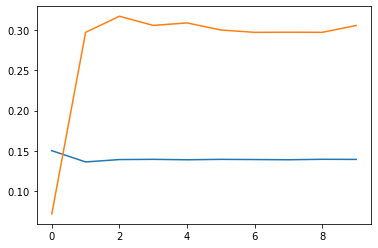

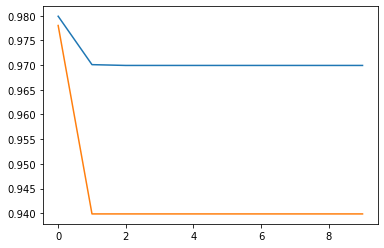


Duomenys pateikiami tf.data.dataset formatu
n_classes: 3
no_features: 19
batch_size: 32
epochs: 10


In [9]:
#   APMOKYMO ISTORIJA

print('\nMokymo istorija')
print("\n",history.params)

print(history.history.keys()) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()



In [6]:
# Confusion matrix
# https://stackoverflow.com/questions/64622210/how-to-extract-classes-from-prefetched-dataset-in-tensorflow-for-confusion-matri

from sklearn.metrics import confusion_matrix, classification_report
# https://stackoverflow.com/questions/66672375/tf-accuracy-score-and-confusion-matrix-disagree-is-tensorflow-shuffling-data-on

y_pred_class = np.array([])
y_true_class = np.array([])

# iterate over the dataset
for feature_batch, label_batch in ds_validation:   # use dataset.unbatch() with repeat
  
   # append true labels
   true_class_batch = np.argmax(label_batch, axis=1)
   # print(true_class)
   y_true_class = np.concatenate([y_true_class, true_class_batch])

   # compute predictions
   preds_batch = model.predict(feature_batch)
   # append predicted labels
   pred_class_batch = np.argmax(preds_batch, axis = 1)
   # print(pred_class)
   y_pred_class = np.concatenate([y_pred_class, pred_class_batch])

print('\ny_true_class:')
print(y_true_class)
print('\ny_pred_class:')
print(y_pred_class)

print('\nconfusion_matrix\n')
print(confusion_matrix(y_true_class, y_pred_class))

print('\nclassification_report\n')
print(classification_report(y_true_class, y_pred_class))
 


y_true_class:
[0. 0. 0. ... 0. 0. 0.]

y_pred_class:
[0. 0. 0. ... 0. 0. 0.]

confusion_matrix

[[1525    0    2]
 [   0    0    9]
 [   0    0    1]]

classification_report

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1527
         1.0       0.00      0.00      0.00         9
         2.0       0.08      1.00      0.15         1

    accuracy                           0.99      1537
   macro avg       0.36      0.67      0.38      1537
weighted avg       0.99      0.99      0.99      1537



c:\Users\Lenovo\miniconda3\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\miniconda3\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Lenovo\miniconda3\envs\ecg\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Bandymai su CNN klasifikatoriumi
seq_length = 19
n_classes = 3
epochs=10
verbose=2

# model = tf.keras.Sequential([
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(10)
# ])

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=seq_length))
# model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPooling1D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
# model.summary()


history = model.fit(ds_train, epochs=epochs, verbose=verbose)

# evaluate the keras model
_, accuracy = model.evaluate(ds_train)
print(f"accuracy: {accuracy:.2f}")


In [ ]:
# Apibrėžiame klasifikavimo modelį ir jo parametrus.
# Apmokome klasifikatorių ir įvertiname jo tikslumą

def create_model(seq_length, num_filters, kernel_size, drop_out, num_dense_nodes, number_of_classes, learning_rate):
# Iš D:\DI\VSC\ZIVEIO\ZIVE&MIT\3_mit2zive_classif_set_v2L.ipynb
# NN CNN modelis su 2 sluoksniais: iš Develop 1D Convolutional Neural Network, Jason Brownlee,
# https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

    # model = Sequential()
    input_tensor = tf.keras.layers.Input(shape=(seq_length,))
    
    # 1st cnn block
    x = tf.keras.layers.Activation('relu')(input_tensor)
    x = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size)(x)

    # 2st cnn block
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv1D(filters=num_filters, kernel_size=kernel_size)(x)
    x = tf.keras.layers.Dropout(drop_out)(x)
    x = tf.keras.layers.MaxPooling1D()(x)

    # mlp
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(num_dense_nodes, activation='relu')(x)
    output_tensor = tf.keras.layers.Dense(number_of_classes, activation='softmax')(x)
        
    # instantiate and compile model
    cnn_model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)  
    cnn_model.compile(loss='categorical_crossentropy',
                                 optimizer=opt, metrics=['accuracy'])
    return cnn_model

epochs=10
verbose=2

num_filters = 64
kernel_size = 3
num_dense_nodes = 100
drop_out = 0.5

seq_length = 19
n_classes = 3
learning_rate = 0.00001


# normalize = tf.keras.layers.Normalization(mean=MEAN, variance=STD)
# normalize.adapt(dt_train,batch_size=batch_size)

cnn_model = create_model(seq_length, num_filters, kernel_size, drop_out, num_dense_nodes, n_classes, learning_rate)
         
start_time = time.time()

history = cnn_model.fit(ds_train, epochs=epochs, verbose=verbose)

# evaluate the keras model
_, accuracy = cnn_model.evaluate(ds_train)
print(f"accuracy: {accuracy:.2f}")
